# Exporting Model Insights and Visuals

## Summary

This notebook presents some examples for taking a datarobot project and exporting its model insights as both machine readable files and plots in various file formats.

This notebook will demonstrate how to use the Python API client to:

1. Setting up the environment: Import necessary libraries
2. Securely Connect to DataRobot
3. Get data
4. Start a DataRobot binary classification project
5. Retrieve and evaluate model performance and insights
6. Package up insights and output them in various file formats

## Imports

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import datarobot as dr
import datarobotx as drx
from datarobotx.viz.charts import feature_impact_chart, roc_curve_chart
from matplotlib.animation import FuncAnimation
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

## Connect to DataRobot and create a project

In [2]:
# Connect to DataRobot
dr.Client(config_path="./drconfig.yaml")

In [22]:
data = pd.read_csv("https://s3.amazonaws.com/datarobot_public_datasets/10k_diabetes.csv")

In [4]:
data.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,Surgery-Neuro,...,No,No,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified"
1,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,?,...,No,No,No,No,No,No,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia
2,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,Family/GeneralPractice,...,No,No,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia
3,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,?,...,No,No,No,No,No,Yes,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...
4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,Psychiatry,...,No,No,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis


In [ ]:
project = dr.Project.create(data, project_name="10k diabetes Readmissions")

In [ ]:
target = "readmitted"
advanced_options = dr.AdvancedOptions(
    prepare_model_for_deployment=False,
    consider_blenders_in_recommendation=False,
    run_leakage_removed_feature_list=False,
)

In [ ]:
project.analyze_and_model(
    target=target,
    metric="LogLoss",
    advanced_options=advanced_options,
    mode=dr.AUTOPILOT_MODE.QUICK,
    worker_count=-1,
)
project.wait_for_autopilot()

In progress: 9, queued: 0 (waited: 0s)
In progress: 9, queued: 0 (waited: 0s)
In progress: 9, queued: 0 (waited: 1s)
In progress: 9, queued: 0 (waited: 2s)


In progress: 9, queued: 0 (waited: 3s)
In progress: 9, queued: 0 (waited: 5s)


In progress: 9, queued: 0 (waited: 9s)


In progress: 9, queued: 0 (waited: 16s)


In progress: 9, queued: 0 (waited: 29s)


In progress: 9, queued: 0 (waited: 49s)


In progress: 1, queued: 0 (waited: 70s)


In progress: 16, queued: 0 (waited: 90s)


In progress: 13, queued: 0 (waited: 110s)


In progress: 0, queued: 0 (waited: 131s)


In progress: 0, queued: 0 (waited: 151s)


In [5]:
# Leaving this here for testing, rather than waiting for whole project to build
project = dr.Project.get("65a16328dc2ce073056c7f2c")

In [ ]:
project.id

'65a16328dc2ce073056c7f2c'

### Now that the project has finished running, we'll grab the top performing model and export different metrics and insights in variosu formats

In [6]:
top_model = project.get_top_model()

In [7]:
print(top_model.model_type)

eXtreme Gradient Boosted Trees Classifier with Early Stopping


#### To emulate the style of the lift chart from DataRobot's UI, we will use the following helper functions

In [8]:
def rebin_df(raw_df, number_of_bins):
    cols = ["bin", "actual_mean", "predicted_mean", "bin_weight"]
    new_df = pd.DataFrame(columns=cols)
    current_prediction_total = 0
    current_actual_total = 0
    current_row_total = 0
    x_index = 1
    bin_size = 60 / number_of_bins
    for rowId, data in raw_df.iterrows():
        current_prediction_total += data["predicted"] * data["bin_weight"]
        current_actual_total += data["actual"] * data["bin_weight"]
        current_row_total += data["bin_weight"]

        if (rowId + 1) % bin_size == 0:
            x_index += 1
            bin_properties = {
                "bin": ((round(rowId + 1) / 60) * number_of_bins),
                "actual_mean": current_actual_total / current_row_total,
                "predicted_mean": current_prediction_total / current_row_total,
                "bin_weight": current_row_total,
            }

            new_df = new_df.append(bin_properties, ignore_index=True)
            current_prediction_total = 0
            current_actual_total = 0
            current_row_total = 0
    return new_df


def matplotlib_lift(bins_df, bin_count, ax):
    grouped = rebin_df(bins_df, bin_count)
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["predicted_mean"],
        marker="+",
        lw=1,
        color=dr_blue,
        label="Predicted",
    )
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["actual_mean"],
        marker="*",
        lw=1,
        color=dr_orange,
        label="Actual",
    )
    ax.set_xlim([0, len(grouped) + 1])
    ax.set_facecolor(dr_dark_blue)
    ax.legend(loc="best")
    ax.set_title("Lift chart {} bins".format(bin_count))
    ax.set_xlabel("Sorted Prediction")
    ax.set_ylabel("Value")
    return grouped


dr_dark_blue = "#08233F"
dr_blue = "#1F77B4"
dr_orange = "#FF7F0E"
dr_red = "#BE3C28"

#### And then we can generate lift charts at various bin sizes and export them in a wide variety of file formats.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


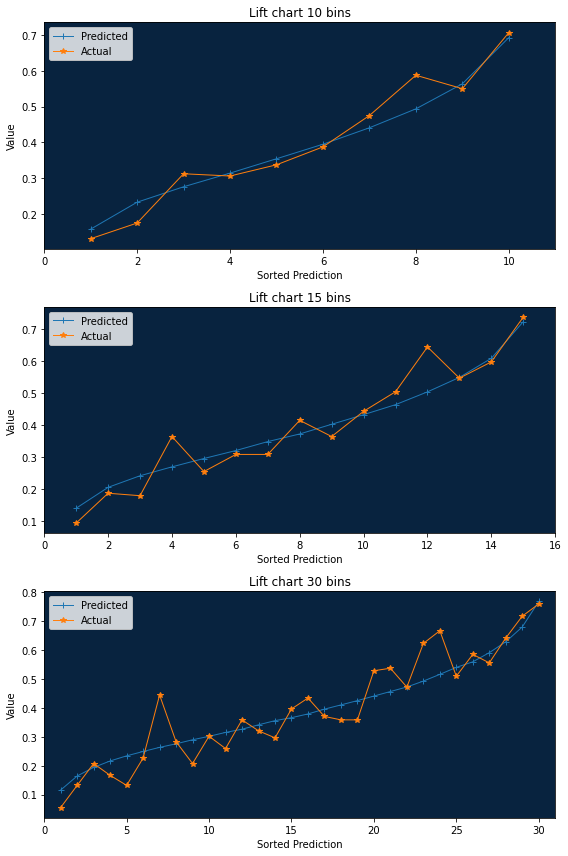

In [9]:
lc = top_model.get_lift_chart("validation")

bins_df = pd.DataFrame(lc.bins)
bin_counts = [10, 15, 30]
f, axarr = plt.subplots(len(bin_counts))
f.set_size_inches((8, 4 * len(bin_counts)))

rebinned_dfs = []
for i in range(len(bin_counts)):
    rebinned_dfs.append(matplotlib_lift(bins_df, bin_counts[i], axarr[i]))
plt.tight_layout()

# Saving the plot in various file formats supported by matplotlib
plt.savefig("./LiftCharts/Lift Chart.pdf", format="pdf", bbox_inches="tight")
plt.savefig("./LiftCharts/Lift Chart.svg", format="svg", bbox_inches="tight")
plt.savefig("./LiftCharts/Lift Chart.png", format="png", bbox_inches="tight")
plt.savefig("./LiftCharts/Lift Chart.eps", format="eps", bbox_inches="tight")
plt.savefig("./LiftCharts/Lift Chart.jpeg", format="jpeg", bbox_inches="tight")

In [10]:
# For a compelte list of formats supported by matplotlib, run the following
plt.gcf().canvas.get_supported_filetypes()

{'eps': 'Encapsulated Postscript',
 'jpg': 'Joint Photographic Experts Group',
 'jpeg': 'Joint Photographic Experts Group',
 'pdf': 'Portable Document Format',
 'pgf': 'PGF code for LaTeX',
 'png': 'Portable Network Graphics',
 'ps': 'Postscript',
 'raw': 'Raw RGBA bitmap',
 'rgba': 'Raw RGBA bitmap',
 'svg': 'Scalable Vector Graphics',
 'svgz': 'Scalable Vector Graphics',
 'tif': 'Tagged Image File Format',
 'tiff': 'Tagged Image File Format'}

<Figure size 432x288 with 0 Axes>

In [11]:
# rebinned_dfs contains each of the three different binning aproaches for our lift charts
for df in rebinned_dfs:
    num_bins = len(df)
    # We can also save the lift chart data as a csv file
    df.to_csv(f"./LiftCharts/lift-chart-{num_bins}-bins.csv", index=False)

We can also utilize matplotlib's animation library to make animated plots and save them as gifs.

In [12]:
def AnimationFunction(frame, df_list):
    ax.clear()

    df = df_list[frame]
    num_bins = len(df)

    ax.plot(df["bin"], df["actual_mean"], marker="*", lw=1, color=dr_orange, label="Actual")
    ax.plot(df["bin"], df["predicted_mean"], marker="+", lw=1, color=dr_blue, label="Predicted")
    ax.set_xlim([0, num_bins + 1])
    ax.set_facecolor(dr_dark_blue)
    ax.legend(loc="best")
    ax.set_title("Lift chart {} bins".format(num_bins))
    ax.set_xlabel("Sorted Prediction")
    ax.set_ylabel("Value")

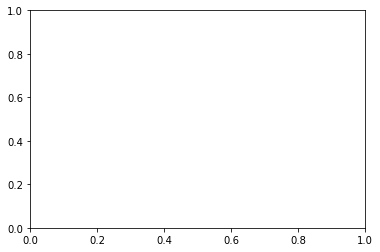

In [13]:
fig, ax = plt.subplots()
anim_created = FuncAnimation(fig, AnimationFunction, frames=3, interval=1000, fargs=(rebinned_dfs,))

In [14]:
anim_created.save(
    "./LiftCharts/lift-chart-all-bins.gif",
)

MovieWriter ffmpeg unavailable; using Pillow instead.


#### We can iterate through all of the models in our project and export various different performance metrics (in this case the Log Loss scores), and save them as a csv file.

In [15]:
model_scores = {"model": [], "cv0": [], "cv1": [], "cv2": [], "cv3": [], "cv4": []}

# first, make sure all the models have cross validation scores
for model in project.get_models():
    print(model.model_type)
    if model.metrics["LogLoss"]["crossValidation"] is None:
        print("running cross validation")
        model.cross_validate()

eXtreme Gradient Boosted Trees Classifier with Early Stopping
Light Gradient Boosted Trees Classifier with Early Stopping
Light Gradient Boosting on ElasticNet Predictions 
Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)
Generalized Additive2 Model
Elastic-Net Classifier (L2 / Binomial Deviance)
RuleFit Classifier
RandomForest Classifier (Gini)
Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)


In [16]:
# Get LogLoss values for all models
for model in project.get_models():
    logloss_cv = model.get_cross_validation_scores()["cvScores"]["LogLoss"]

    model_scores["model"].append(model.model_type)
    model_scores["cv0"].append(logloss_cv["0.0"])
    model_scores["cv1"].append(logloss_cv["1.0"])
    model_scores["cv2"].append(logloss_cv["2.0"])
    model_scores["cv3"].append(logloss_cv["3.0"])
    model_scores["cv4"].append(logloss_cv["4.0"])

In [17]:
logloss_scores = pd.DataFrame(model_scores)
logloss_scores.to_csv("./models_logloss_scores.csv", index=False)
logloss_scores.head()

,model,cv0,cv1,cv2,cv3,cv4
0,eXtreme Gradient Boosted Trees Classifier with...,0.60652,0.60264,0.61049,0.61547,0.60600
1,Light Gradient Boosted Trees Classifier with E...,0.60667,0.60184,0.61076,0.61428,0.60711
2,Light Gradient Boosting on ElasticNet Predicti...,0.60752,0.60222,0.61665,0.61759,0.60810
3,Elastic-Net Classifier (mixing alpha=0.5 / Bin...,0.60941,0.61105,0.61762,0.61719,0.60847
4,Generalized Additive2 Model,0.61074,0.60341,0.61737,0.61699,0.60962


#### There is also a library called [datarobotx](https://drx.datarobot.com/index.html) that acts as a way to generalize or streamline many of the actions you can perform through the DataRobot API. In this case we can, in one line, create a feature impact or ROC curve plot and save them in anyway an altair chart can be saved.

In [18]:
drx.Context(config_path="./drconfig.yaml")

feature_impact_chart(project.id, top_model.id)

VBox()

alt.Chart(...)

In [19]:
roc_curve_chart(project.id, top_model.id)

VBox()

alt.LayerChart(...)

In [20]:
# The charts created by drx are altair plots and can be saved in multiple file formats
fi_chart = feature_impact_chart(project.id, top_model.id)
fi_chart.save("./feature_impact.svg")

VBox()